In [1]:
import os
def dummy_plot(input):
    plt.plot(range(len(input)), input)
os.chdir('/Users/richb/Documents/deleteme/z0_reqfiles')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pyfftw.interfaces.numpy_fft import fftn,ifftn
from scipy.ndimage import gaussian_filter1d
# import h5py

verbose = True

eV = 1/27.2114
Angstrom = 1/0.5291772

#Get mu, lattice vectors and grid from output file:
R = np.zeros((3,3))
iLine = 0
refLine = -10
initDone = False
Rdone = False
Sdone = False
for line in open('out'):
	if line.startswith('Initialization completed'):
		initDone = True
	if initDone and line.find('FillingsUpdate:')>=0:
		mu = float(line.split()[2])
	if line.find('Initializing the Grid') >= 0:
		refLine = iLine
	if not Rdone:
		rowNum = iLine - (refLine+2)
		if rowNum>=0 and rowNum<3:
			R[rowNum,:] = [ float(x) for x in line.split()[1:-1] ]
		if rowNum==3:
			Rdone = True
	if (not Sdone) and line.startswith('Chosen fftbox size'):
		if verbose: print(line)
		S = np.array([ int(x) for x in line.split()[-4:-1] ])
		if verbose: print(S)
		Sdone = True
	iLine += 1

# Z-grid stuff
Lz = np.linalg.norm(R[:,2])
Nz = S[2]
dz = Lz/Nz

Chosen fftbox size, S = [  108  108  196  ]

[108 108 196]


In [3]:
verbose = True
wk = [] # k-weights for each state (fraction of total reciprocal volume of BZ)
iGarr = [] # G-vectors for each state
for line in open('Gvectors'):
	if line.startswith('#'):
		if verbose: print(line.split())
		if verbose: print(float(line.split()[-1]))
		# wk should collect the k point weights, not spin
		# the if/else below should correct this
		if line.split()[-1] == 'spin':
			wk.append(float(line.split()[-3]))
		else:
			wk.append(float(line.split()[-1]))
		iGcur = []
	elif len(line)>1:
		iGcur.append([int(tok) for tok in line.split()])
	else:
		iGarr.append(np.array(iGcur))
nStates = len(wk)

#Eigenavlues:
E = (np.fromfile("eigenvals") - mu)/eV
print(np.shape(E))
# The "-1" in the reshape is like an autofill to find a "y" length which is compatible with the "x" length to the original vector length
# equivalent to E.reshape(nStates, len(E)/nStates)
E = E.reshape(nStates,-1)
print(np.shape(E))
nBands = E.shape[1]
print(np.shape(E))

#Energy grid (eV):
Emin = -2. #eV (relative to mu)
Emax = +2. #eV
dE = 0.01 #eV
Egrid = np.arange(Emin, Emax+0.1*dE, dE)
nE = Egrid.shape[0]
ldos = np.zeros((nE, S[2]))

['#', '0', '[', '+0.0000000', '+0.0000000', '+0.0000000', ']', '0.250000000', 'spin', '+1']
1.0
['#', '1', '[', '+0.0000000', '+0.5000000', '+0.0000000', ']', '0.250000000', 'spin', '+1']
1.0
['#', '2', '[', '+0.5000000', '+0.0000000', '+0.0000000', ']', '0.250000000', 'spin', '+1']
1.0
['#', '3', '[', '+0.5000000', '+0.5000000', '+0.0000000', ']', '0.250000000', 'spin', '+1']
1.0
['#', '4', '[', '+0.0000000', '+0.0000000', '+0.0000000', ']', '0.250000000', 'spin', '-1']
-1.0
['#', '5', '[', '+0.0000000', '+0.5000000', '+0.0000000', ']', '0.250000000', 'spin', '-1']
-1.0
['#', '6', '[', '+0.5000000', '+0.0000000', '+0.0000000', ']', '0.250000000', 'spin', '-1']
-1.0
['#', '7', '[', '+0.5000000', '+0.5000000', '+0.0000000', ']', '0.250000000', 'spin', '-1']
-1.0
(1016,)
(8, 127)
(8, 127)


In [12]:
min_idcs = [10000, 10000, 10000]
max_idcs = [-100000, -10000, -10000]
for i, iGcur in enumerate(iGarr):
	print('G-vectors within expansion of state ' + str(i) + ':')
	print(len(iGcur))
	print('min h index of G-vectors for state ' + str(i) + ':')
	print(min(iGcur[:,0]))
# print(min_idcs)
# print(max_idcs)
# print(S/max_idcs)

G-vectors within expansion of state 0:
87069
min h index of G-vectors for state 0:
-23
G-vectors within expansion of state 1:
86968
min h index of G-vectors for state 1:
-23
G-vectors within expansion of state 2:
87078
min h index of G-vectors for state 2:
-24
G-vectors within expansion of state 3:
87078
min h index of G-vectors for state 3:
-24
G-vectors within expansion of state 4:
87069
min h index of G-vectors for state 4:
-23
G-vectors within expansion of state 5:
86968
min h index of G-vectors for state 5:
-23
G-vectors within expansion of state 6:
87078
min h index of G-vectors for state 6:
-24
G-vectors within expansion of state 7:
87078
min h index of G-vectors for state 7:
-24


In [13]:
verbose = True
#Read and process wavefunctions, looping over states:
#iGarr = array of length # states (8 here), with each entry containing array of length # G vectors incorporated into the state (represented by miller indices [h, k, l])
with open('wfns') as fp:
	for iState, iGcur in enumerate(iGarr):
		if verbose: print('iState=' + str(iState))
		if verbose: print('iGcur=' + str(iGcur))
		wkCur = wk[iState]
		if verbose: print('wkCur=' + str(wkCur))
		if verbose: print('Processing', iState+1, 'of', nStates)
		#Basis indices:
		nG = iGcur.shape[0]
		if verbose: print('nG=' + str(nG))
		# This line says to add a version of iGcur to itself, where each miller index becomes either
		# 0 if its greater than 0, or the corresponding G-grid length if its less than 0.
		# So in total we're just pacmaning negative miller indices to the other side of the G-grid so that they
		# correspond to a positive integer index. For a 1D G-grid, this might look like:
		# [-3, -2, -1, 0, 1, 2, 3] --> [0, 1, 2, 3, ... , -3, -2, -1]
		iGcur += np.where(iGcur<0, S[None,:], 0)
		if verbose: print('iGcur is now ' + str(iGcur))
		stride = np.array([S[2]*S[1], S[2], 1], dtype=int)
		if verbose: print('stride=' + str(stride))
		# index is a list of ints which give the places where wfn values corr. to dif miller indices will be stored
		index = np.dot(iGcur, stride)
		if verbose: print('index=' + str(index))
		#Read wavefunctions:
		# Since we're calling the np.fromfile on the same open('wfns'), the pointer is left at the end
		# of the previous count. This way we can partition the wavefunction file into each of the 8
		# states despite them having non-equal lengths
		C = np.reshape(np.fromfile(fp, dtype=np.complex128, count=nBands*nG), (nBands, nG))
		#Process band-by-band:
		# psiTilde of length x*y*z SINCE our G-grid appears to be of the same dimension
		psiTilde = np.zeros(np.prod(S), dtype=np.complex128)
		for iBand in range(nBands):
			#Energy insertion point:
			# eigenvalue of particular band wrt an arbitrary Emin (-2 here) div by an arbitrary dE (0.01 here)
			xE = (E[iState,iBand] - Emin)/dE
			# the index of the same energy E[iState,iBand] in our Egrid we're plotting
			# (we could have also done Egrid.index(E[iState,iBand]) if we had a way to
			# better round E[iState,iBand] to a value contained in Egrid
			iE = int(np.floor(xE))
			# nE is the number of energy points we're plotting
			# (so checking that our energy index is not outside of the Egrid indices)
			if iE>=0 and iE+1<nE:
				# tE is whatever float was curtailed in getting iE - why is this relevant?
				tE = xE-iE
				# C[index] will be of length (# of incorporated G-vectors)
				# so this will put the corresponding wavefunction val
				if verbose: print(str(iState)+', '+str(iBand))
				if verbose: print(np.linalg.norm(psiTilde))
				psiTilde[index] = C[iBand] # Why is psiTilde not reset to zeros before doing this?
				# BECAUSE the indices we're sending to are the same for each iBand (only changes upon switching to next iState)
				if verbose: print(np.linalg.norm(psiTilde))
				# convert to real space
				psi = ifftn(np.reshape(psiTilde, S)) * np.prod(S)
				n = (np.abs(psi)**2).mean(axis=1).mean(axis=0) #planarly average
				# Multiply by spin??
				if verbose: print('spin is ' + str(wkCur))
				if verbose: print('sum of n is ' + str(np.sum(n)))
				n *= wkCur/(dE*dz*np.sum(n)) #normalize by z integral
				if verbose: print('shape of n is ' + str(np.shape(n)))
				ldos[iE] += n*(1.-tE)
				ldos[iE+1] += n*tE

iState=0
iGcur=[[-23   7  -5]
 [-23   7  -4]
 [-23   7  -3]
 ...
 [ 23  -7   3]
 [ 23  -7   4]
 [ 23  -7   5]]
wkCur=1.0
Processing 1 of 8
nG=87069
iGcur is now [[ 85   7 191]
 [ 85   7 192]
 [ 85   7 193]
 ...
 [ 23 101   3]
 [ 23 101   4]
 [ 23 101   5]]
stride=[21168   196     1]
index=[1800843 1800844 1800845 ...  506663  506664  506665]
0, 102
0.0
0.0067010682243105945
spin is 1.0
sum of n is 0.008801245807985594
shape of n is (196,)
0, 103
0.0067010682243105945
0.006698592060285887
spin is 1.0
sum of n is 0.008794742575664512
shape of n is (196,)
0, 104
0.006698592060285887
0.0066602659307670635
spin is 1.0
sum of n is 0.00869439188463314
shape of n is (196,)
0, 105
0.0066602659307670635
0.00667804463309668
spin is 1.0
sum of n is 0.008740870903839758
shape of n is (196,)
0, 106
0.00667804463309668
0.00667442245660901
spin is 1.0
sum of n is 0.008731391365340182
shape of n is (196,)
0, 107
0.00667442245660901
0.0066588118666286175
spin is 1.0
sum of n is 0.008690595993130202
shap

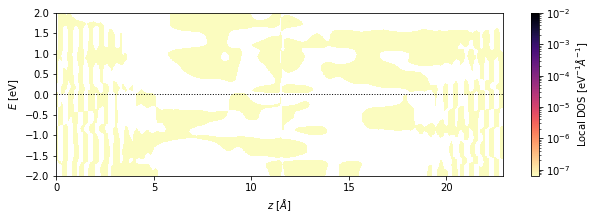

In [14]:
#Gauss smoothing:
Esigma = 5e-3/eV
ldos = gaussian_filter1d(ldos, Esigma/dE, axis=0)

plt.figure(1, figsize=(10,3))
plt.imshow(ldos, origin='lower', extent=[0.,Lz/Angstrom, Emin,Emax],
	norm=colors.LogNorm(0.01, ldos.max()), aspect='auto', cmap='magma_r')
plt.ylabel(r'$E$ [eV]')
plt.xlabel(r'$z$ [$\AA$]')
plt.colorbar(label='DOS').set_label('Local DOS [eV$^{-1}\AA^{-1}$]')
plt.axhline(0., color='k', ls='dotted', lw=1)
#plt.savefig('localDOS.pdf', bbox_inches='tight')

In [4]:
#Extract geometry from totalE.out:
iLine = 0
refLine = -10
R = np.zeros((3,3))
Rdone = False
ionPosStarted = False
ionNames = []
ionPos = []
for line in open('out'):
	#Lattice vectors:
	if line.find('Initializing the Grid') >= 0 and (not Rdone):
		refLine = iLine
	rowNum = iLine - (refLine+2)
	if rowNum>=0 and rowNum<3:
		R[rowNum,:] = [ float(x) for x in line.split()[1:-1] ]
	if rowNum==3:
		refLine = -10
		Rdone = True
	#Coordinate system and ionic positions:
	if ionPosStarted:
		tokens = line.split()
		if len(tokens) and tokens[0] == 'ion':
			ionNames.append(tokens[1])
			ionPos.append([float(tokens[2]),float(tokens[3]),float(tokens[4])])
		else:
			break
	if line.find('# Ionic positions in') >= 0:
		coords = line.split()[4]
		ionPosStarted = True
	#Line counter:
	iLine += 1

for iLine,line in enumerate(open('bandProjections')):
	tokens = line.split()
	if iLine==0:
		if verbose: print('line0 as tokens: ' + str(tokens))
		nStates = int(tokens[0])
		nBands = int(tokens[2])
		nProj = int(tokens[4])
		print('# of projections per state and band: ' + str(nProj))
		nSpecies = int(tokens[6])
		proj = np.zeros((nStates,nBands,nProj))
		nOrbsPerAtom = [] #number of orbitals per atom
	elif iLine>=2:
		print('iLine=' + str(iLine))
		if iLine<nSpecies+2:
			print('passed first conditional')
			print('all tokens: ' + str(tokens))
			nAtoms = int(tokens[1])
			nOrbsPerAtom.extend( [int(tokens[2]),] * nAtoms )
			print('orbs per atom updated: ' + str(nOrbsPerAtom))
		else:
			print('didnt pass first conditional')
			iState = (iLine-(nSpecies+2)) // (nBands+1)
			print('iState: ' + str(iState))
			iBand = (iLine-(nSpecies+2)) - iState*(nBands+1) - 1 # This negative one makes the header line become iBand=-1
			print('iBand: ' + str(iBand))
			# if iBand < 0:
			# 	print('tokens for negative band (?)')
			# 	print(tokens)
			if iBand>=0 and iState<nStates:
				print('computed projections for iBand ' + str(iBand) + ', iState ' + str(iState) + ' length: ')
				print(len(tokens))
				proj[iState,iBand] = np.array([float(tok) for tok in tokens])
	print('---------------------------------')

line0 as tokens: ['8', 'states,', '127', 'bands,', '204', 'orbital-projections,', '3', 'species']
# of projections per state and band: 204
---------------------------------
---------------------------------
iLine=2
passed first conditional
all tokens: ['C', '44', '4', '1', '1', '1']
orbs per atom updated: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
---------------------------------
iLine=3
passed first conditional
all tokens: ['N', '4', '4', '1', '1', '1']
orbs per atom updated: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
---------------------------------
iLine=4
passed first conditional
all tokens: ['Pt', '1', '12', '2', '1', '2', '1']
orbs per atom updated: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

In [34]:
with open('wfns') as fp:
	nBandsx = 127
	nGx = 86968
	C1 = np.reshape(np.fromfile(fp, dtype=np.complex128, count=4), (2, 2))
	C2 = np.reshape(np.fromfile(fp, dtype=np.complex128, count=4), (2, 2))
	# C2 = np.fromfile(fp, dtype=np.complex128, count=nBandsx*nGx).reshape((nBandsx,nGx))
	print(C1[0][0])
	print(C2[0][0])

(-1.2013216749184083e-07+1.4292133646291237e-09j)
(-1.2991602071604942e-07+8.908602323773245e-09j)


In [36]:
with open('wfns') as fp:
	C1 = np.fromfile(fp, dtype=np.complex128, count=4)
	C2 = np.fromfile(fp, dtype=np.complex128, count=4)
	print(C1)
	print(C2)

[-1.20132167e-07+1.42921336e-09j  1.23884414e-07-3.23232443e-09j
 -1.26766028e-07+5.10342877e-09j  1.28777149e-07-7.00731187e-09j]
[-1.29916021e-07+8.90860232e-09j  1.30185292e-07-1.07722754e-08j
 -1.29587069e-07+1.25636916e-08j  1.28125432e-07-1.42484432e-08j]


In [25]:
np.shape(C)[0]/127

87069.0

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.colors as colors
# from pyfftw.interfaces.numpy_fft import fftn,ifftn
# from scipy.ndimage import gaussian_filter1d
# import h5py
#
# eV = 1/27.2114
# Angstrom = 1/0.5291772
#
# #Get mu, lattice vectors and grid from output file:
# R = np.zeros((3,3))
# iLine = 0
# refLine = -10
# initDone = False
# Rdone = False
# Sdone = False
# for line in open('totalE.out'):
# 	if line.startswith('Initialization completed'):
# 		initDone = True
# 	if initDone and line.find('FillingsUpdate:')>=0:
# 		mu = float(line.split()[2])
# 	if line.find('Initializing the Grid') >= 0:
# 		refLine = iLine
# 	if not Rdone:
# 		rowNum = iLine - (refLine+2)
# 		if rowNum>=0 and rowNum<3:
# 			R[rowNum,:] = [ float(x) for x in line.split()[1:-1] ]
# 		if rowNum==3:
# 			Rdone = True
# 	if (not Sdone) and line.startswith('Chosen fftbox size'):
# 		S = np.array([ int(x) for x in line.split()[-4:-1] ])
# 		Sdone = True
# 	iLine += 1
# Lz = np.linalg.norm(R[:,2])
# Nz = S[2]
# dz = Lz/Nz
#
# #G-vectors and k weights:
# wk = []
# iGarr = []
# for line in open('totalE.Gvectors'):
# 	if line.startswith('#'):
# 		wk.append(float(line.split()[-1]))
# 		iGcur = []
# 	elif len(line)>1:
# 		iGcur.append([int(tok) for tok in line.split()])
# 	else:
# 		iGarr.append(np.array(iGcur))
# nStates = len(wk)
#
# #Eigenavlues:
# E = (np.fromfile("totalE.eigenvals") - mu)/eV
# E = E.reshape(nStates,-1)
# nBands = E.shape[1]
#
# #Energy grid (eV):
# Emin = -2. #eV (relative to mu)
# Emax = +2. #eV
# dE = 0.01 #eV
# Egrid = np.arange(Emin, Emax+0.1*dE, dE)
# nE = Egrid.shape[0]
# ldos = np.zeros((nE, S[2]))
#
# #Read and process wavefunctions, looping over states:
# with open('totalE.wfns') as fp:
# 	for iState, iGcur in enumerate(iGarr):
# 		wkCur = wk[iState]
# 		print('Processing', iState+1, 'of', nStates)
# 		#Basis indices:
# 		nG = iGcur.shape[0]
# 		iGcur += np.where(iGcur<0, S[None,:], 0)
# 		stride = np.array([S[2]*S[1], S[2], 1], dtype=int)
# 		index = np.dot(iGcur, stride)
# 		#Read wavefunctions:
# 		C = np.reshape(np.fromfile(fp, dtype=np.complex128, count=nBands*nG), (nBands, nG))
# 		#Process band-by-band:
# 		psiTilde = np.zeros(np.prod(S), dtype=np.complex128)
# 		for iBand in range(nBands):
# 			#Energy insertion point:
# 			xE = (E[iState,iBand] - Emin)/dE
# 			iE = int(np.floor(xE))
# 			if iE>=0 and iE+1<nE:
# 				tE = xE-iE
# 				psiTilde[index] = C[iBand]
# 				psi = ifftn(np.reshape(psiTilde, S)) * np.prod(S)
# 				n = (np.abs(psi)**2).mean(axis=1).mean(axis=0) #planarly average
# 				n *= wkCur/(dE*dz*np.sum(n)) #normalize by z integral
# 				ldos[iE] += n*(1.-tE)
# 				ldos[iE+1] += n*tE
#
# #Gauss smoothing:
# Esigma = 5e-3/eV
# ldos = gaussian_filter1d(ldos, Esigma/dE, axis=0)
#
# plt.figure(1, figsize=(10,3))
# plt.imshow(ldos, origin='lower', extent=[0.,Lz/Angstrom, Emin,Emax],
# 	norm=colors.LogNorm(0.01, ldos.max()), aspect='auto', cmap='magma_r')
# plt.ylabel(r'$E$ [eV]')
# plt.xlabel(r'$z$ [$\AA$]')
# plt.colorbar(label='DOS').set_label('Local DOS [eV$^{-1}\AA^{-1}$]')
# plt.axhline(0., color='k', ls='dotted', lw=1)
# plt.savefig('localDOS.pdf', bbox_inches='tight')